In [1]:
print("Hello world")

Hello world


In [2]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd
import emcee
import corner
import multiprocessing, time

data= pd.read_csv("semf.csv", header=0, names=['A', 'Z', 'm_atom', 'error'])
A = data['A']
Z = data['Z']
m_atom = data['m_atom']
el = data['error']
A = np.array(A)
Z = np.array(Z)
m_atom = np.array(m_atom)
el = np.array(el)

In [3]:
# 1 u = 931494.10242 keV (2018 value)
m_H= 1.007825
m_n= 1.008665
c2= 931494.10242
m_atom= (m_atom/c2)+ A

m_nucleons= (Z*m_H)+ ((A-Z)*m_n)
m_defect = m_nucleons - m_atom
BE= m_defect * c2    # in keV, experimental

In [4]:
def E_B_theory(a_v, a_s, a_c, a_asy, a_p, A, Z):
#    a_p_array = np.where(A % 2 == 0, np.where(Z % 2 == 0, a_p, -a_p), 0)
    N = A - Z
    a_p_array = np.where((Z % 2 == 0) & (N % 2 == 0), a_p,
                         np.where((Z % 2 == 1) & (N % 2 == 1), -a_p, 0))
    B_theory = (a_v * A 
                - a_s * A**(2/3) 
                - a_c * Z * (Z - 1) / A**(1/3) 
                - a_asy * (A - 2 * Z)**2 / A 
                + a_p_array)
    return B_theory

def ln_likelihood(A, Z, BE, el, a_v, a_s, a_c, a_asy, a_p):
    chi2 = np.sum((BE - E_B_theory(a_v, a_s, a_c, a_asy, a_p, A, Z))**2 / el**2)
    return -0.5 * chi2


In [25]:
def ln_prior(theta ):
      a_v, a_s, a_c, a_asy, a_p= theta
    #   if not (14 < a_v < 17):
    #       return -np.inf
    #   if not (-27 < a_s < -12):
    #       return -np.inf
    #   if not ( -0.774 < a_c < -0.669 ):
    #       return -np.inf
    #   if not (-32.87 < a_asy < -20.82):
    #       return -np.inf
    #   if not (9 < a_p < 12):
      if not (14 < a_v < 19):
          return -np.inf
      if not (-30 < a_s < -17):
          return -np.inf
      if not ( -0.800 < a_c < -0.700 ):
          return -np.inf
      if not (-34 < a_asy < -24):
          return -np.inf
      if not (9 < a_p < 12):
          return -np.inf
      return 0.0


In [26]:
def ln_post(theta, A, Z, BE, el):
    a_v, a_s, a_c, a_asy, a_p = theta
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_L = ln_likelihood(A, Z, BE, el, a_v, a_s, a_c, a_asy, a_p)
    if not np.isfinite(ln_L):
        return -np.inf
    return ln_p + ln_L


### burnin
=  2 × max(tau)

In [39]:
# ---- MCMC SETUP ----
ndim = 5           # No. of parameters
nwalkers = 25      # Number of independent chains ("walkers")
nsteps = 40000      # Steps each walker takes
burnin = 1600      # Discard these initial steps (they're still "warming up")
#(800*2)
# ---- INITIAL GUESS FOR WALKERS ----
np.random.seed(42)
init_guess = [15.46, -18.13 , -0.711, -25.13, 10.66]  # Rough center of prior a_b, sig_b, a_d, sig_d, rho, h
pos =  np.array([init_guess] * nwalkers) + np.random.normal(0, [ 0.45, 3.16, 0.025, 3.67, 0.55], (nwalkers, ndim))


In [40]:
import multiprocessing
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post,
            args=(A, Z, BE, el),
            pool=pool
        )
        sampler.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)


  0%|          | 0/40000 [00:00<?, ?it/s]/home/nina/code/mywork/experiments/.venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 40000/40000 [05:08<00:00, 129.77it/s]


Shape of samples: (960000, 5)


### emcee chains shape: 
(nsteps, nwalkers, ndim)
when flattened: (nsteps × nwalkers, ndim)

N $\ge 50 \times \tau$ 
Repeat until
N > 50 × max(tau)


In [41]:
print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))          # 
tau = sampler.get_autocorr_time()
print(tau)


Mean acceptance fraction: 0.35556600000000005
[101.51685469 121.30084616 250.90324547 245.48551443 733.86421598]


### All sampled values of the 5 parameters

In [42]:
a_v = flat_samples[:, 0]  
a_s = flat_samples[:, 1]  
a_c = flat_samples[:, 2] 
a_asy = flat_samples[:, 3] 
a_p= flat_samples[:, 4]

# ---- SUMMARIZE RESULTS ----
print(f"a_b = {np.mean(a_v):.3f} ± {np.std(a_v):.3f}")                # EDIT THE NAME ab_samp ONCE GRAPH IS OBTAINED, EDIT FOR HERNQUIST AS WELL
print(f"sigma_b = {np.mean(a_s):.3f} ± {np.std(a_s):.3f}")
print(f"a_d = {np.mean(a_c):.3f} ± {np.std(a_c):.3f}")
print(f"sigma_d = {np.mean(a_asy):.3f} ± {np.std(a_asy):.3f}")
print(f"rho_0 = {np.mean(a_p):.3f} ± {np.std(a_p):.3f}")

a_b = 19.000 ± 0.000
sigma_b = -30.000 ± 0.000
a_d = -0.800 ± 0.000
sigma_d = -34.000 ± 0.000
rho_0 = 11.969 ± 0.031


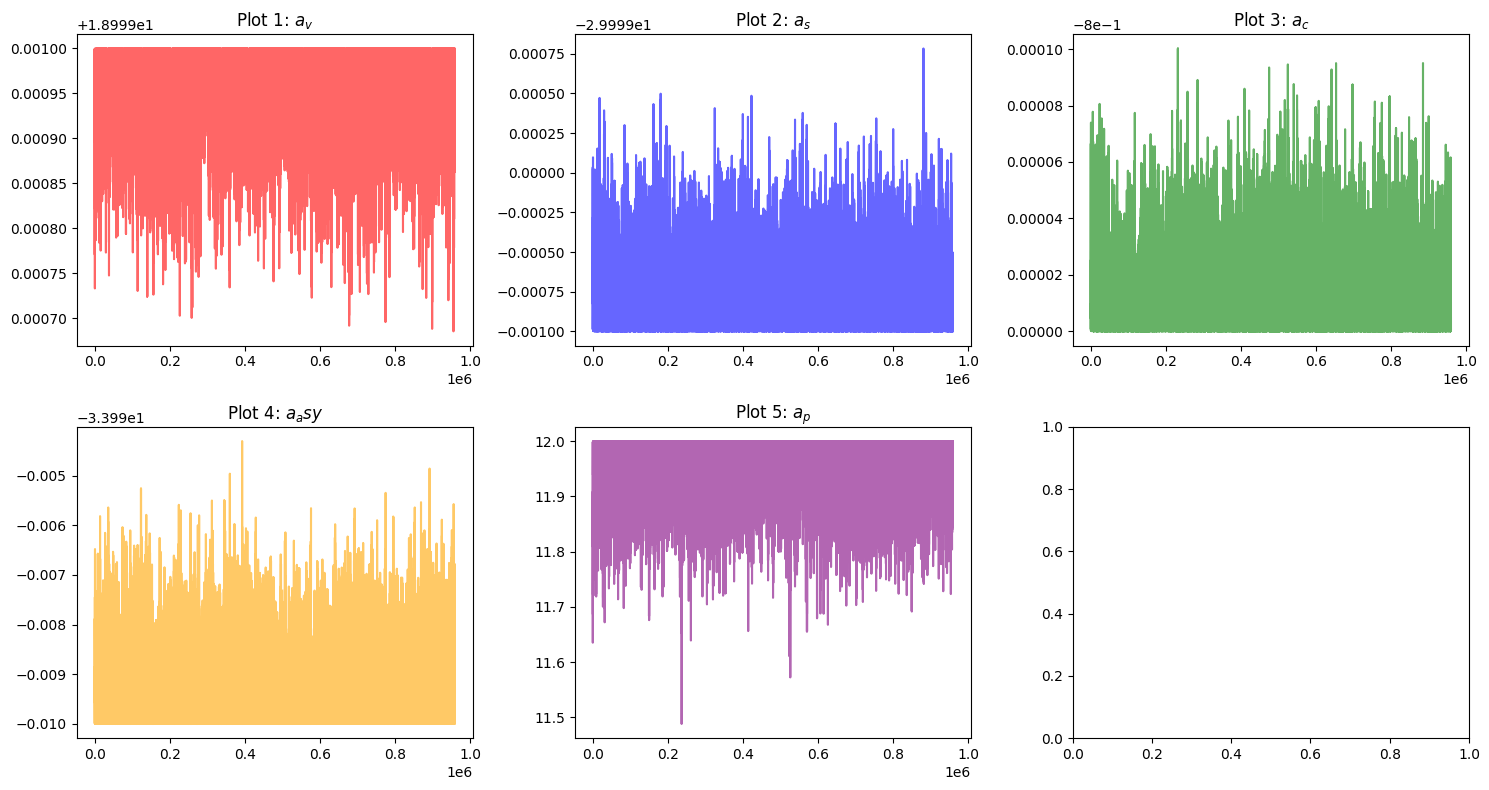

In [43]:
# Setup: 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Flatten for easier indexing
axes = axes.flatten()

# Plot 1
axes[0].plot(a_v, alpha=0.6, color='red')
axes[0].set_title("Plot 1: $a_v$")

# Plot 2
axes[1].plot(a_s, alpha=0.6, color='blue')
axes[1].set_title("Plot 2: $a_s$")

# Plot 3
axes[2].plot(a_c, alpha=0.6, color='green')
axes[2].set_title("Plot 3: $a_c$")

# Plot 4
axes[3].plot(a_asy, alpha=0.6, color='orange')
axes[3].set_title("Plot 4: $a_asy$")

# Plot 5
axes[4].plot(a_p, alpha=0.6, color='purple')
axes[4].set_title("Plot 5: $a_p$")


plt.tight_layout()
plt.show()

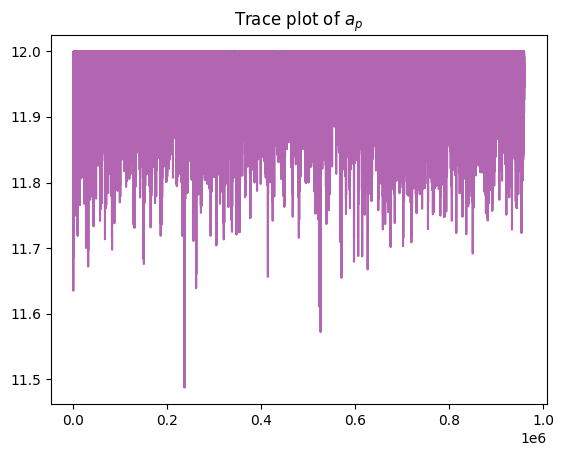

In [44]:
plt.plot(a_p, alpha=0.6, color='purple')
plt.title("Trace plot of $a_p$")
plt.show()

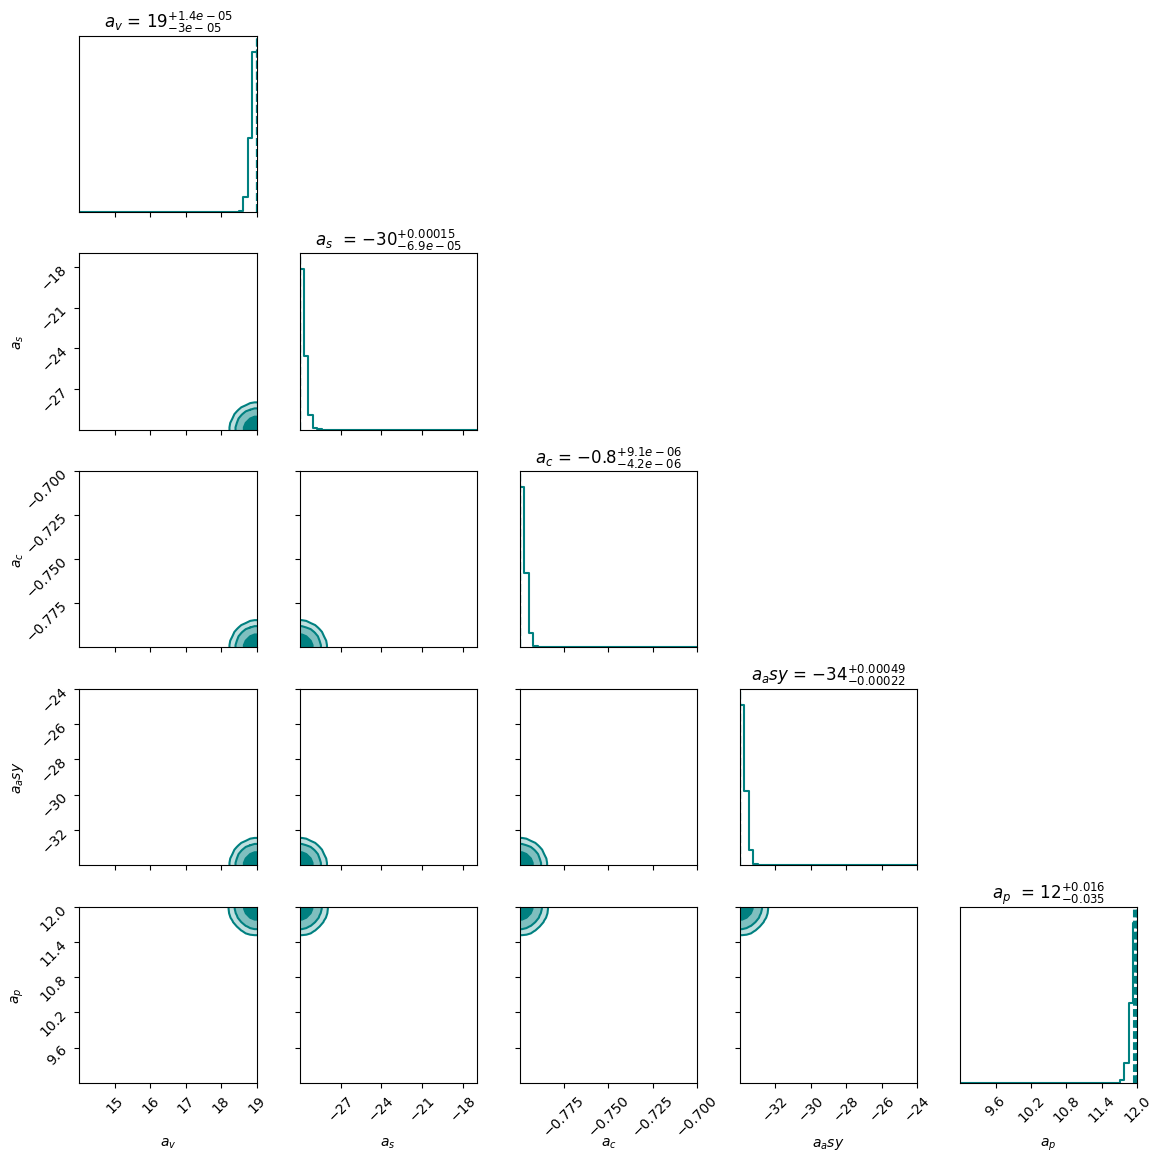

In [45]:
'''     a_v, a_s, a_c, a_asy, a_p= theta
      if not (16.2 < a_v < 20):
          return -np.inf
      if not (-30 < a_s < -21):
          return -np.inf
      if not ( -0.795 < a_c < -0.750 ):
          return -np.inf
      if not (-35 < a_asy < -30):
          return -np.inf
      if not (11 < a_p < 14):
      Trial #2
            if not (14 < a_v < 19):
          return -np.inf
      if not (-30 < a_s < -17):
          return -np.inf
      if not ( -0.800 < a_c < -0.700 ):
          return -np.inf
      if not (-34 < a_asy < -24):
          return -np.inf
      if not (9 < a_p < 12):
          return -np.inf
          '''
corner.corner(
    flat_samples,                                                                             
    labels=["$a_v$", "$a_s$ ", "$a_c$", "$a_asy$", "$a_p$ "],
    bins=40,
    color="teal",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=2.0, smooth1d=1.0,
    title_fmt=".2g",
    show_titles=True,
    range= [(14,19), (-30,-17), (-0.800,-0.700), (-34,-24), (9,12)]
)
plt.tight_layout()
plt.show()